# Import Packages, Functions and Data

In [1]:
import titanlib
import geopandas
import pandas as pd
import netCDF4
import numpy as np

from mpl_toolkits.axes_grid1 import make_axes_locatable
import datetime
import time



# Import custom version of titanlib containing changes
import titanlibcustom



# Import Formatted Data and functions from other Python script
from Data_Importation_and_Function_Definition import ROI_counties, NI_counties, rain_wow, rain_wow_hourly_obs, temp_wow, rain_official, temp_official, isolate_data_of_interest, plot_wow_data

Note: As advised, the Official Rainfall Rate column is currently beign set as equal to the 
Rainfall Accumulation Hourly column


# Obtain Test Data

In [2]:
gdf_temp_wow, gdf_temp_official, gdf_temp_combined = isolate_data_of_interest(day_of_interest="15", 
                                                                              month_of_interest="05",
                                                                              year_of_interest="2021", 
                                                                              time_of_interest="10",
                                                                              type_of_data="Temperature", 
                                                                              add_elevation_bool=True,
                                                                              remove_missing_val=True, 
                                                                              cols_to_remove_missing_val=["Air Temperature"])

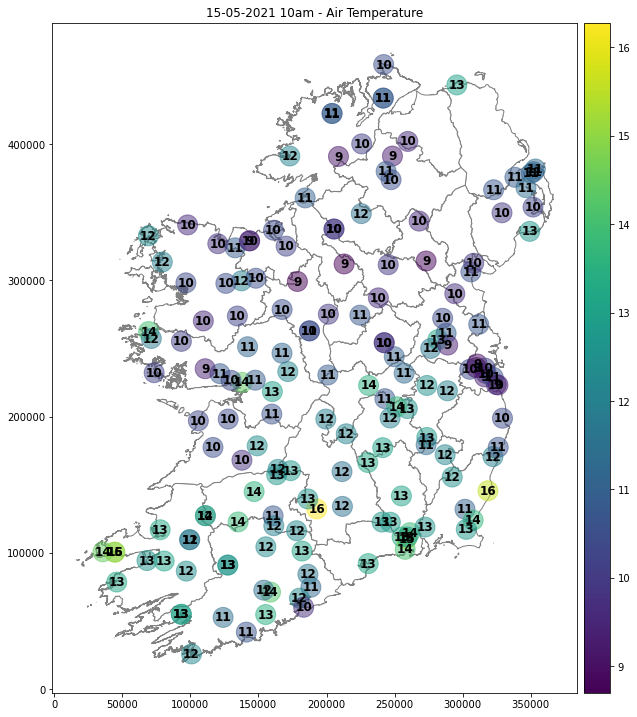

In [3]:
plot_wow_data(gdf_of_interest = gdf_temp_combined, type_of_plot = "Air Temperature", 
              buffer_val = 0, flags = None)

In [4]:
# By default let's discard any missing data from Rainfall Accumulation, Rainfall Accumulation Hourly
# or Rainfall Rate.

# Note if we were only interested in one of these values we could maximise our data points by only
# removing missing values from the column of interest
gdf_rain_wow, gdf_rain_official, gdf_rain_combined = isolate_data_of_interest(day_of_interest="15", 
                                                                              month_of_interest="05",
                                                                              year_of_interest="2021", 
                                                                              time_of_interest="10",
                                                                              type_of_data="Rainfall", 
                                                                              add_elevation_bool=True,
                                                                              remove_missing_val=True, 
                                                                              cols_to_remove_missing_val=["Rainfall Accumulation", 
                                                                                                          "Rainfall Accumulation Hourly", 
                                                                                                          "Rainfall Rate"])

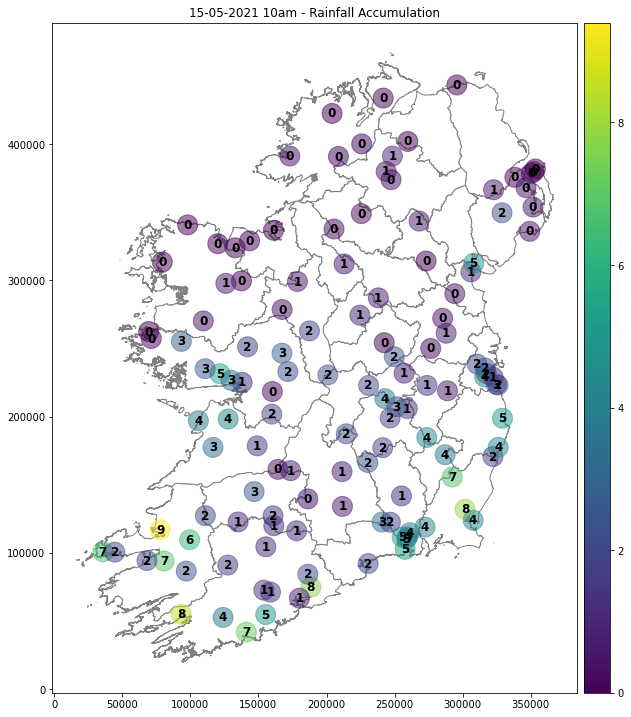

In [5]:
plot_wow_data(gdf_of_interest = gdf_rain_combined, type_of_plot = "Rainfall Accumulation", 
              buffer_val = 0, flags = None)

# First Guess Check

## Adapted Github Example

In [6]:
lats = np.array([60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60])
lons = 10 + np.array([i*0.005 for i in range(len(lats))])
elevs = np.zeros(len(lats))
values = np.round(10*np.sin(lons*2*np.pi/(max(lons)-min(lons))),2)
# values = np.array([10, 12, 14, 16, 14, 12, 12, 12, 14, 12, 12])
obs_to_check = np.ones(len(lats))
background_values = np.zeros(len(lats))
background_uncertainties = np.ones(len(lats))
#background_elab_type = "MedianOuterCircle"
background_elab_type = titanlib.MedianOuterCircle
N = len(lats)
num_min_outer = 3
num_max_outer = 10
inner_radius = 20000
outer_radius = 50000
num_iterations = 10
num_min_prof = 0
min_elev_diff = 100
min_horizontal_scale = 250 
max_horizontal_scale = 100000
kth_closest_obs_horizontal_scale = 2
tpos = np.ones(N) * 5
tneg = np.ones(N) * 5
values_mina = values - 20
values_maxa = values + 20
values_minv = values - 1
values_maxv = values + 1
debug = False
points = titanlib.Points(lats, lons, elevs)

flags = titanlib.fgt(points, values, obs_to_check, background_values, background_uncertainties, 
                     background_elab_type, num_min_outer, num_max_outer, inner_radius, outer_radius, 
                     num_iterations, num_min_prof, min_elev_diff, values_mina, values_maxa, values_minv, 
                     values_maxv, tpos, tneg, debug)

flags

[array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32),
 array([-999., -999., -999., -999., -999., -999., -999., -999., -999.,
        -999., -999.], dtype=float32)]

## Custom Example

In [7]:
lats = [53, 53.5, 53, 52.5, 53, 54, 53.5, 52.5, 52, 52.5, 53.5]
lons = [-8, -8, -7.5, -8, -8.5, -8, -7, -7, -8, -9, -9]

vals = [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]

test_df = pd.DataFrame(list(zip(lats, lons, vals)))

test_df.rename(columns={0: "Latitude", 1: "Longitude", 2: "Air Temperature"}, inplace = True)

test_df["Day"] = "n/a"
test_df["Month"] = "n/a"
test_df["Year"] = "n/a"
test_df["Time"] = "n/a"

# Convert data of interest into a GeoDataFrame for plotting
test_gdf = geopandas.GeoDataFrame(test_df, 
                                  geometry=geopandas.points_from_xy(test_df.Longitude, 
                                                                    test_df.Latitude))

test_gdf.crs = {"init":"epsg:4326"} # initialise the dataframe to have a crs
test_gdf = test_gdf.to_crs({'init': 'epsg:29902'}) # convert crs to Irish Grid Projection

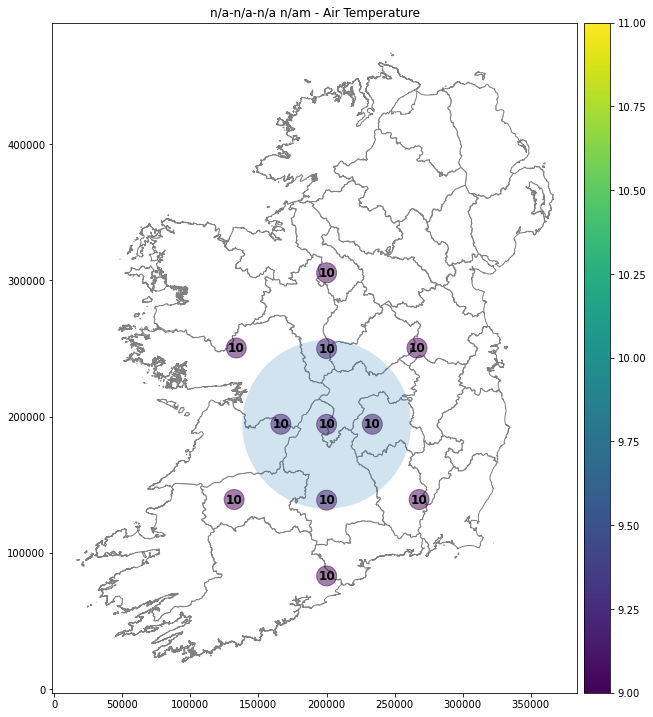

In [8]:
buffer_val_list = np.zeros(len(test_gdf), dtype = int)
buffer_val_list[0] = 62000
buffer_val_list = list(buffer_val_list)

plot_wow_data(test_gdf, type_of_plot = "Air Temperature", 
                  buffer_val = buffer_val_list, flags = None)

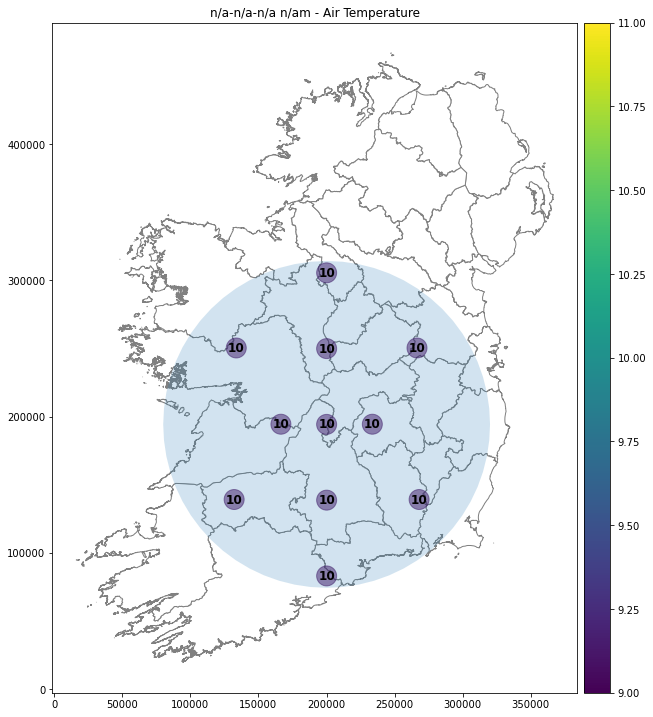

In [9]:
buffer_val_list = np.zeros(len(test_gdf), dtype = int)
buffer_val_list[0] = 120000
buffer_val_list = list(buffer_val_list)

plot_wow_data(test_gdf, type_of_plot = "Air Temperature", 
                  buffer_val = buffer_val_list, flags = None)

In [10]:
elevs = np.zeros(len(lats))
obs_to_check = np.ones(len(lats))
background_values = np.zeros(len(lats))
background_uncertainties = np.ones(len(lats))
background_elab_type = titanlib.MedianOuterCircle
N = len(lats)
num_min_outer = 3
num_max_outer = 999 # Our goal is not to optimize speed here so let's include all observations
inner_radius = 62000
outer_radius = 120000
num_iterations = 10
num_min_prof = 0
min_elev_diff = 100
min_horizontal_scale = 250 
max_horizontal_scale = 100000
kth_closest_obs_horizontal_scale = 2
tpos = np.ones(N) * 3 # Let's flag anything 3 standard deviations away from the background val
tneg = np.ones(N) * 3 # Let's flag anything 3 standard deviations away from the background val

values = np.array(test_gdf["Air Temperature"], dtype=float)

# Let's Purposefully create a very large admissible range for understanding background vals
# as otherwise the value of the background is bounded by mina and maxa.
values_mina = values.copy() - 1000 
values_maxa = values.copy() + 1000

values_minv = values - 1
values_maxv = values + 1
debug = False

points = titanlib.Points(test_gdf["Latitude"], test_gdf["Longitude"], elevs)

### Flag 11 - Isolated inner circle (< 2 stations)

In [11]:
inner_radius = 62000

flags = titanlib.fgt(points, values, obs_to_check, background_values, background_uncertainties, 
                     background_elab_type, num_min_outer, num_max_outer, inner_radius, outer_radius, 
                     num_iterations, num_min_prof, min_elev_diff, values_mina, values_maxa, values_minv, 
                     values_maxv, tpos, tneg, debug)

flags

[array([ 0,  0,  0,  0,  0,  0, 11, 11,  0, 11, 11], dtype=int32),
 array([-999., -999., -999., -999., -999., -999., -999., -999., -999.,
        -999., -999.], dtype=float32)]

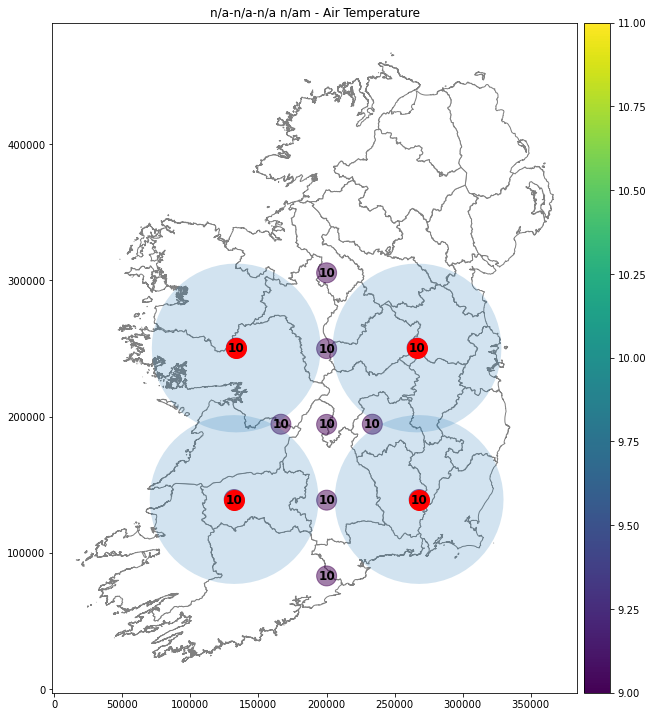

In [12]:
binary_flags = (flags[0] != 0)

buffer_val_list = np.zeros(len(test_gdf), dtype = int)
indices = [binary_flags]
buffer_val_list[tuple(indices)] = inner_radius
buffer_val_list = list(buffer_val_list)

plot_wow_data(test_gdf, type_of_plot = "Air Temperature", 
                  buffer_val = buffer_val_list, flags = binary_flags)

### Flag 12 - Isolated outer circle (< num_min_outer stations)

In [13]:
outer_radius = 75000 # decreased outer radius to cause flag 12 (isolated outer circle)
inner_radius = 70000 # increased inner radius to avoid flag 11 (isolated inner circle)
num_min_outer = 3 # same as before, just a reminder

flags = titanlib.fgt(points, values, obs_to_check, background_values, background_uncertainties, 
                     background_elab_type, num_min_outer, num_max_outer, inner_radius, outer_radius, 
                     num_iterations, num_min_prof, min_elev_diff, values_mina, values_maxa, values_minv, 
                     values_maxv, tpos, tneg, debug)

flags

[array([ 0,  0,  0,  0,  0, 12,  0,  0, 12,  0,  0], dtype=int32),
 array([-999., -999., -999., -999., -999., -999., -999., -999., -999.,
        -999., -999.], dtype=float32)]

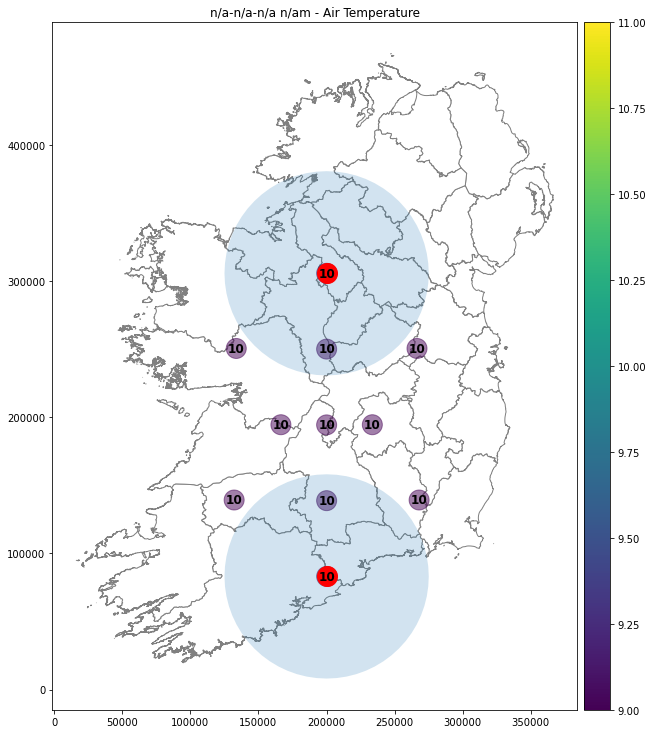

In [14]:
binary_flags = (flags[0] != 0)

buffer_val_list = np.zeros(len(test_gdf), dtype = int)
indices = [binary_flags]
buffer_val_list[tuple(indices)] = outer_radius
buffer_val_list = list(buffer_val_list)

plot_wow_data(test_gdf, type_of_plot = "Air Temperature", 
                  buffer_val = buffer_val_list, flags = binary_flags)

### Flag -999 - Station not checked

In [15]:
outer_radius = 120000 # increased outer radius to avoid flag 12 (isolated outer circle)
inner_radius = 70000 # increased inner radius to avoid flag 11 (isolated inner circle)
num_min_outer = 3 # same as before

obs_to_check = np.ones(len(lats))
dont_check = [3, 8, 10]
obs_to_check[dont_check] = 0


flags = titanlib.fgt(points, values, obs_to_check, background_values, background_uncertainties, 
                     background_elab_type, num_min_outer, num_max_outer, inner_radius, outer_radius, 
                     num_iterations, num_min_prof, min_elev_diff, values_mina, values_maxa, values_minv, 
                     values_maxv, tpos, tneg, debug)

flags

[array([   0,    0,    0, -999,    0,    0,    0,    0, -999,    0, -999],
       dtype=int32),
 array([-999., -999., -999., -999., -999., -999., -999., -999., -999.,
        -999., -999.], dtype=float32)]

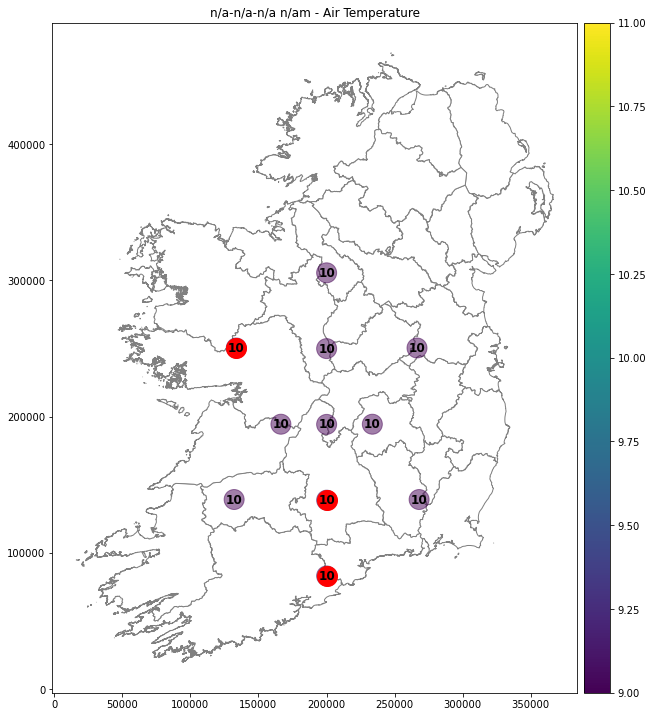

In [16]:
binary_flags = (flags[0] != 0)

plot_wow_data(test_gdf, type_of_plot = "Air Temperature", 
                  buffer_val = 0, flags = binary_flags)

### Flag 1 - Bad observation (rejected by FGT)

First let's just check the central observation and try to get it flagged as a bad observation

To do this we will need to change the value of some of the inner and outer observations. To know what changes to make it is helpful to have a conceptual understanding of the mathematics involved.

Each observation to test is compared against an estimated value (a "first guess" also referred to as the "background" value) which is obtained by considering the neighbouring observations. This background is then used in a kind of buddy check where observations are compared to the reference background value and it is then decided if the observation to test is good or not.
<br>
<br>
<br>

**Parameters/Calculations:**

The first important parameter to understand is $\chi$ and it is calculated as:

$$\chi = \frac{|\textrm{observation} - \textrm{background} |}{\textrm{uncertainty of the background}}$$

The background uncertainty is optional, when not provided it is set to 1. This parameter $\chi$ is then used to calculate a z score:

$$z = \frac{(\chi - \mu)}{(\sigma + \sigma_\mu)}$$

where $\mu = \textrm{median}(\chi)$, $\sigma = \textrm{IQR}(\chi)$, $\sigma_\mu = \sigma / \sqrt{n}$. Note that these statistics are based on the n observations that are within the inner circle
and with a background within the range of admissible values.
<br>
<br>
<br>

**Note 1:** If there is no variation in the inner circle (in fact if the inter quartile range = 0) then to avoid a divide by zero error the fgt is exited early and the value is left as "good".

**Note 2:** These calculations all depend heavily on the value of the background so it is essential that the value is representative of the true data. The method of calculation is also important as for example changing one value in the outer circle to be a very large outlier will cause no change to the background value if the method of calculation is MedianOuterCircle, conversely MeanOuterCircle is susceptible to those large outliers.
<br>
<br>
<br>

**Flagging Observations as Bad:**

An observation is flagged when $z > \textrm{given threshold}$

So, for an observation to be flagged, $\chi$ must be large, $\mu$ must be small and both $\sigma$ and $\sigma_\mu$ cannot be too large. The given threshold must also not be too large.

Practically speaking, for an observation to be flagged: 
1. The difference between the observation being tested and the background must be high. i.e. if the observation being tested and the background value are close the value is probably correct.
2. The median of the differences between the inner circle observations and the background must be small. i.e. most of the other observations within the inner circle should be close to the background value, indicating that the other inner circle points and the background agree with each other and the observation being tested is the odd one out.
3. There cannot be large variances between the differences between the inner circle observations and the background values. i.e. if the inner circle values are all over the place, some agreeing with the background, others disagreeing it is more difficult to conclude that the central observation is the odd one out and should be flagged.

In [17]:
background_elab_type = titanlib.MedianOuterCircle

points = titanlib.Points(test_gdf["Latitude"], test_gdf["Longitude"], elevs)

obs_to_check = np.ones(len(lats))

test_gdf["Air Temperature"] = np.full(len(test_gdf), 10)

# Outer circle stations
# Need to be large enough that the background is high 
# In this case we are using MedianOuterCircle so the 
# Background value will be 100
test_gdf.loc[10, "Air Temperature"] = 100
test_gdf.loc[9, "Air Temperature"] = 100
test_gdf.loc[8, "Air Temperature"] = 100
test_gdf.loc[7, "Air Temperature"] = 100
test_gdf.loc[6, "Air Temperature"] = 100
test_gdf.loc[5, "Air Temperature"] = 100

# Inner circle stations
# Need to have some vairation (to avoid a dividing by zero error)
# Need to mostly agree with the background value (indicating the central value is the odd one out)
# Should not have too high variation
test_gdf.loc[4, "Air Temperature"] = 105
test_gdf.loc[3, "Air Temperature"] = 97
test_gdf.loc[2, "Air Temperature"] = 95
test_gdf.loc[1, "Air Temperature"] = 92




values = np.array(test_gdf["Air Temperature"], dtype=float)


flags = titanlib.fgt(points, values, obs_to_check, background_values, background_uncertainties, 
                     background_elab_type, num_min_outer, num_max_outer, inner_radius, outer_radius, 
                     num_iterations, num_min_prof, min_elev_diff, values_mina, values_maxa, values_minv, 
                     values_maxv, tpos, tneg, debug = True)

flags 

[array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32),
 array([  19.57785, -999.     , -999.     , -999.     , -999.     ,
        -999.     , -999.     , -999.     , -999.     , -999.     ,
        -999.     ], dtype=float32)]

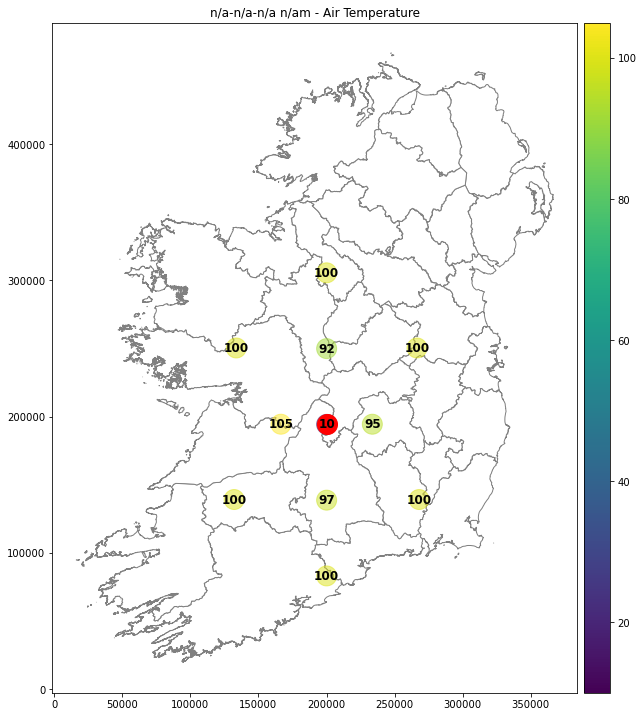

In [18]:
binary_flags = (flags[0] != 0)

plot_wow_data(test_gdf, type_of_plot = "Air Temperature", 
                  buffer_val = 0, flags = binary_flags)

In this example we can see the central observation is being flagged as bad (1) and we can also see that the corresponding z score it had was 19.57785 (which is greater than the allowed 3 standard deviations we set)